# Saving Model Predictions

In [2]:
import segmentation_models as sm
import torch
import matplotlib.pyplot as plt
from tifffile import imwrite

In [3]:
# torch does not recignize datasets as a module when doing torch.load when I do from benchmarking import datasets
import sys
sys.path.insert(0, 'benchmarking/')
import datasets
import get_data

### Create and Load Custom Dataset

In [20]:
!python benchmarking/make_vaa3d_datasets.py --dataset_save_path 'vaa3d_model_visualization_data' --masks_path '/path/to/masks/' --inputs_path '/path/to/inputs/can/be/recursive/' --image_shape 64 128 128

In [3]:
train_dataset, val_dataset, test_dataset = torch.load('vaa3d_model_visualization_data', map_location=datasets)

In [41]:
print(f'Train Data Size: {len(train_dataset)}\tValidation Data Size: {len(val_dataset)}\tTest Data Size: {len(test_dataset)}')

Train Data Size: 64	Validation Data Size: 9	Test Data Size: 9


In [16]:
data_root = None
masks_path = '/Users/rodri/Library/CloudStorage/GoogleDrive-aavelarm@caltech.edu/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_same_size_as_input/'
inputs_path = '/Users/rodri/Library/CloudStorage/GoogleDrive-aavelarm@caltech.edu/My Drive/SURF_2023/Data/BigNeuron/'
custom_dataset = 'vaa3d'
transforms = ['bilinear']
data_len = 89
batch_size = 1
num_workers = 1
seed = 0
ratios = [0.8, 0.1, 0.1]
image_shape = [128, 256, 256]

train_dataset, _ , val_dataset, _ , test_dataset, _ = get_data.CreateDataset(ratios, image_shape, data_root, masks_path, inputs_path, custom_dataset, transforms, data_len, batch_size, num_workers, seed)

### List paths in a dataset

In [69]:
test_dataset.masks_paths

[['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_small/BigN_maskGMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111107_2_C5-right_optic_lobe.v3draw.extract_0.v3dpbd.ano_stamp_2015_06_17_10_12_output.tif'],
 ['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_small/BigN_maskGMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110928_6_E1-left_optic_lobe.v3draw.extract_5.v3dpbd.ano_stamp_2015_06_17_12_22_output.tif'],
 ['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_small/BigN_maskuint8_ChaMARCM-F000139_seg001.lsm_c_3.tif.v3dpbd.ano_stamp_2015_06_15_16_44_output.tif'],
 ['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_small/BigN_maskGMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-left_optic_lobe.v3draw.extract_4.v3dpbd.ano_stamp_2015_06_15_18_57_output.tif'],
 ['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/Vaa3D_masks_small/BigN_maskuint8_ChaMARCM-F000143_seg001.lsm_c_3.tif.v

In [70]:
test_dataset.inputs_paths

['/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111107_2_C5-right_optic_lobe.v3draw.extract_0.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110928_6_E1-left_optic_lobe.v3draw.extract_5.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/uint8_ChaMARCM-F000139_seg001.lsm_c_3.tif.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-left_optic_lobe.v3draw.extract_4.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/uint8_ChaMARCM-F000143_seg001.lsm_c_3.tif.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_small/uint8_ChaMARCM-F000006_seg001.lsm_c_3.tif.v3dpbd.tif',
 '/Users/rodri/Google Drive/My Drive/SURF_2023/Data/BigNeuron/inputs_smal

### Load Model

In [17]:
model_architecture = 'UNet'
spatial_dims = 3
in_channels = 1
out_channels = 1
channels = [64, 128, 256]
strides = [2, 2]
kernel_size = 3

model = sm.Model(model_architecture, spatial_dims, in_channels, out_channels, channels, strides, kernel_size)

In [18]:
# model_path = './benchmarking/saved_models/3D_unet_dice_lr_0.005_batch_1'
model_path = '/Users/rodri/Documents/Caltech/SURF_2023/Code/model_training/EASI_FISH_3D_U_Net/saved_models/3D_unet_method_bilinear_larger_data'
model.load_weights(model_path)

## Vizualize Test Data

In [7]:
def plot_predictions(dataset, save_as='tensor', save_path='', cmap='gray'):
    for i, data in enumerate(dataset):
        image_path = dataset.inputs_paths[i]
        image_name = image_path.split('/')[-1]
        print(f'Image: {image_name}')
        image, label = data
        model.set_image(image)
        model.set_mask(label)
        model.predict()
        model.create_plots(cmap)

        if save_as == 'tensor':
            torch.save(model.prediction, save_path+image_name+'_prediction')
        elif save_as == 'tif':
            imwrite(save_path+image_name+'_prediction.tif', model.prediction.numpy())

In [11]:
save_path = '/Users/rodri/Library/CloudStorage/GoogleDrive-aavelarm@caltech.edu/My Drive/SURF_2023/AllCell/3D CellSAM/'

### Test Dataset Plots

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111005_1_B5-left_optic_lobe.v3draw.extract_3.v3dpbd.tif


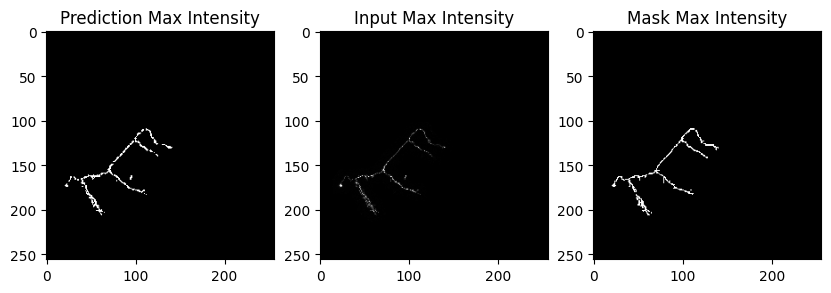

Image: Image7.v3dpbd.tif


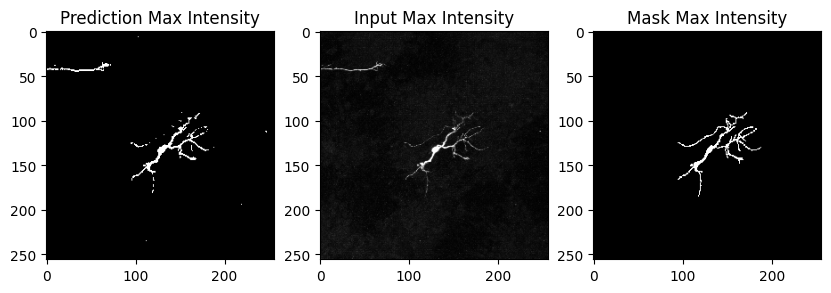

Image: uint8_ChaMARCM-F000144_seg001.lsm_c_3.tif.v3dpbd.tif


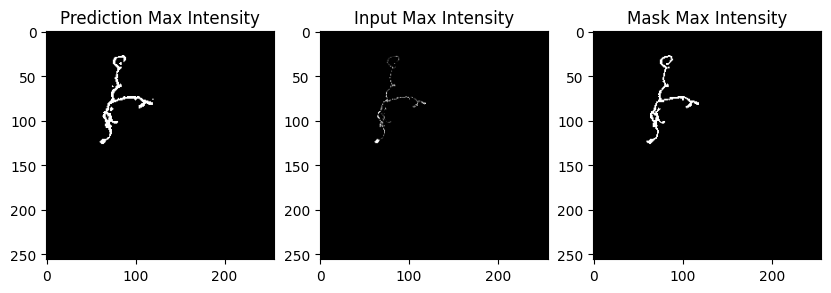

Image: uint8_ChaMARCM-F000126_seg001.lsm_c_3.tif.v3dpbd.tif


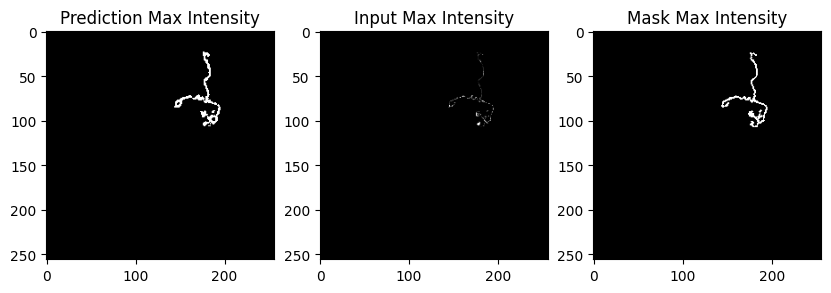

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-x-A02-20110411_1_D4-left_optic_lobe.v3draw.extract_8.v3dpbd.tif


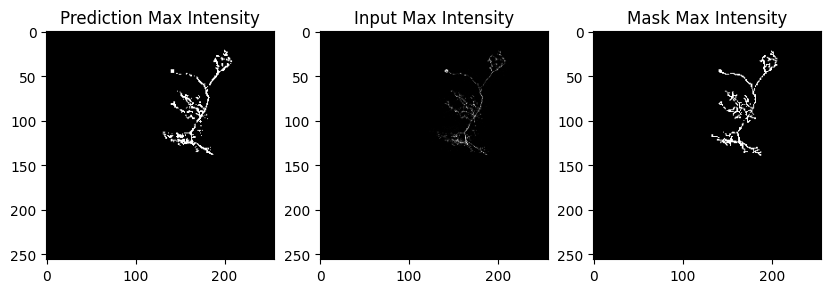

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110928_6_E1-left_optic_lobe.v3draw.extract_5.v3dpbd.tif


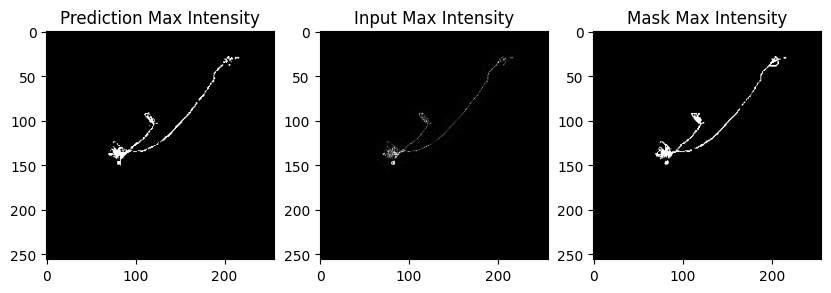

In [19]:
plot_predictions(test_dataset, save_as='', save_path='')

### Validation Dataset Plots

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111005_5_B5-left_optic_lobe.v3draw.extract_0.v3dpbd.tif


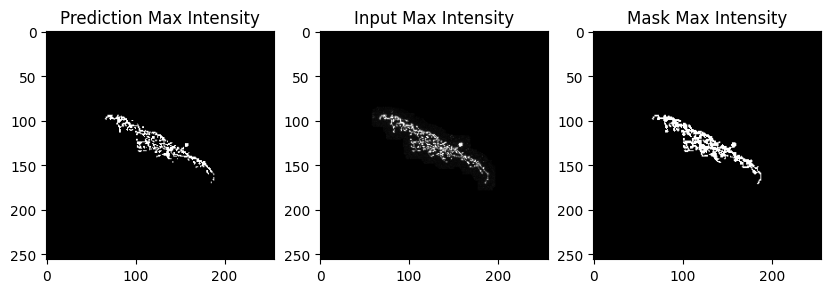

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111103_2_D3-left_optic_lobe.v3draw.extract_0.v3dpbd.tif


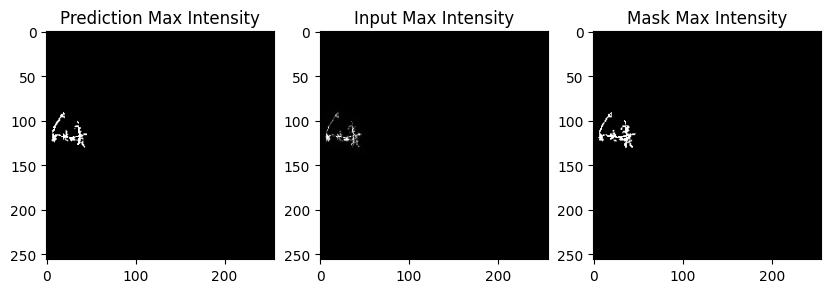

Image: 10-2900-control-cell-05.oif-C0.v3dpbd.tif


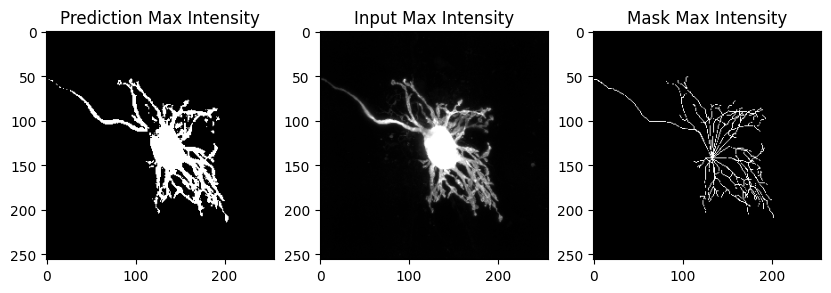

Image: Series009.v3dpbd.tif


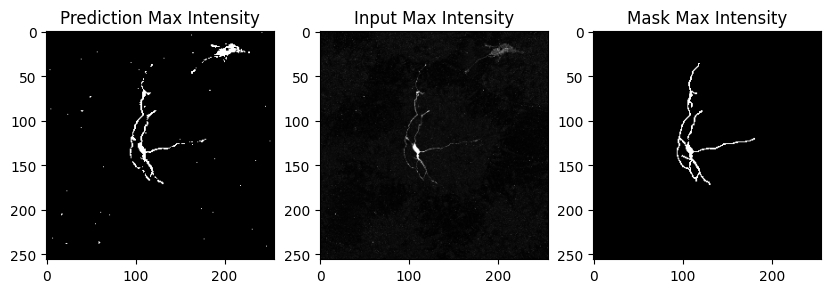

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_C7-left_optic_lobe.v3draw.extract_3.v3dpbd.tif


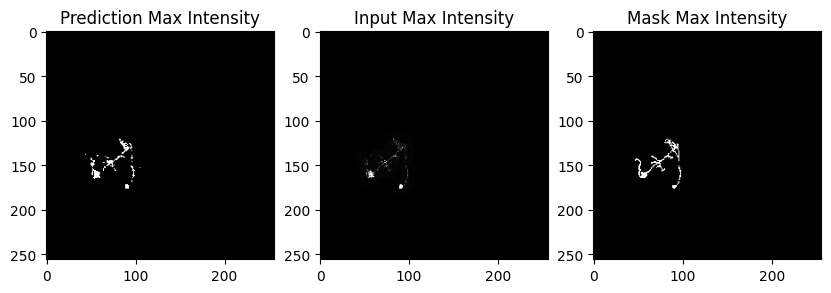

Image: Series019.v3dpbd.tif


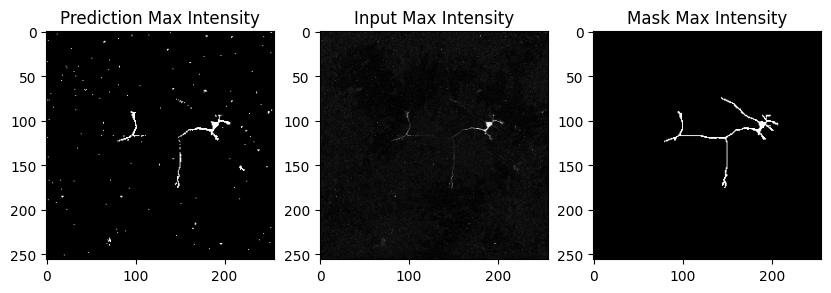

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_E2-right_optic_lobe.v3draw.extract_3.v3dpbd.tif


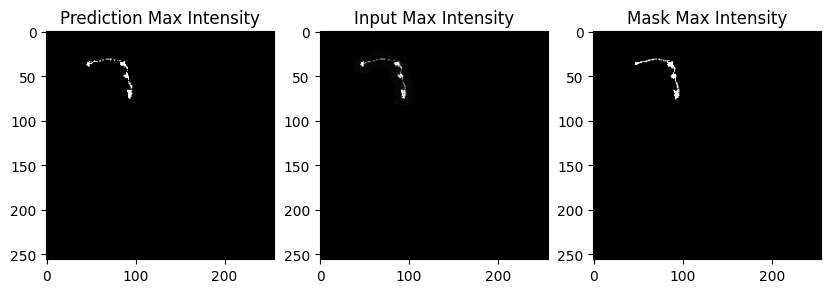

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A6-left_optic_lobe.v3draw.extract_2.v3dpbd.tif


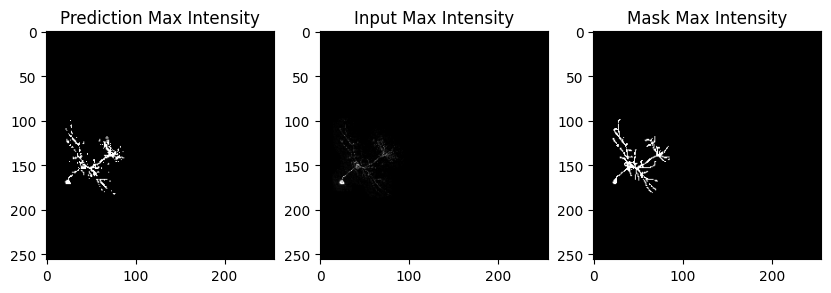

Image: uint8_ChaMARCM-F000134_seg002.lsm_c_3.tif.v3dpbd.tif


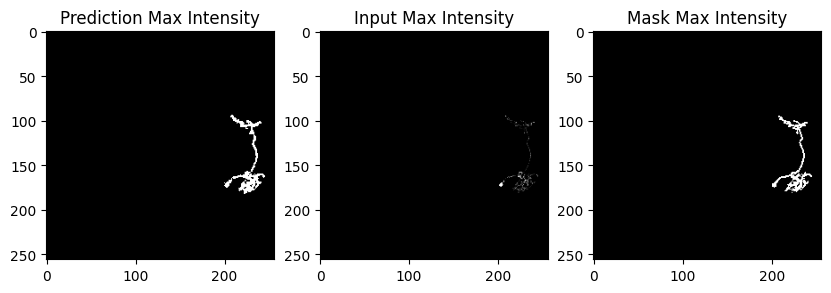

In [20]:
plot_predictions(val_dataset, save_as='', save_path='')

### Train Dataset Plots

Image: uint8_ChaMARCM-F000007_seg001.lsm_c_3.tif.v3dpbd.tif


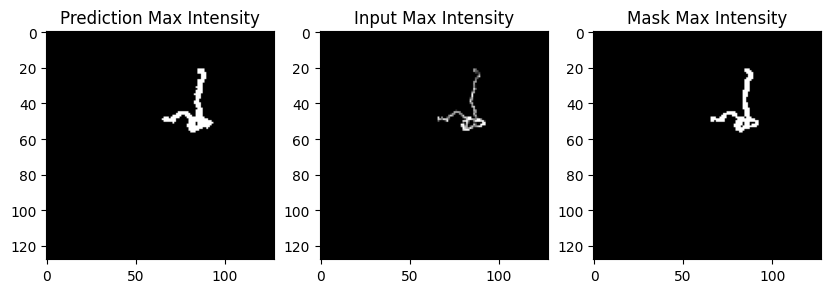

Image: uint8_ChaMARCM-F000135_seg001.lsm_c_3.tif.v3dpbd.tif


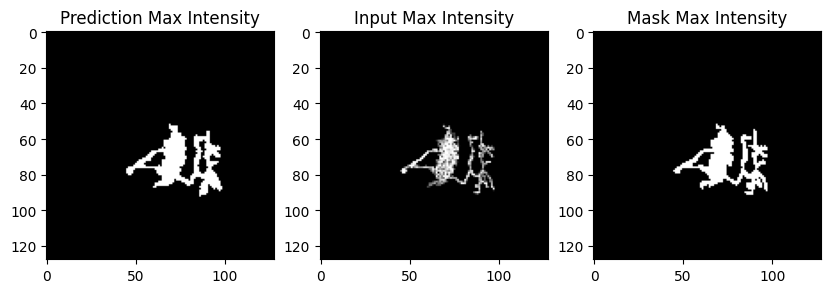

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-left_optic_lobe.v3draw.extract_4.v3dpbd.tif


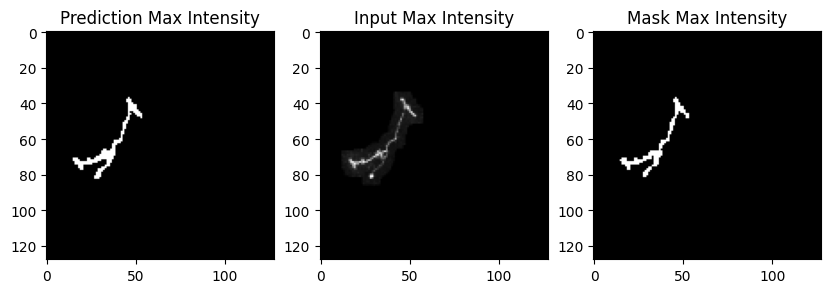

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A7-right_optic_lobe.v3draw.extract_2.v3dpbd.tif


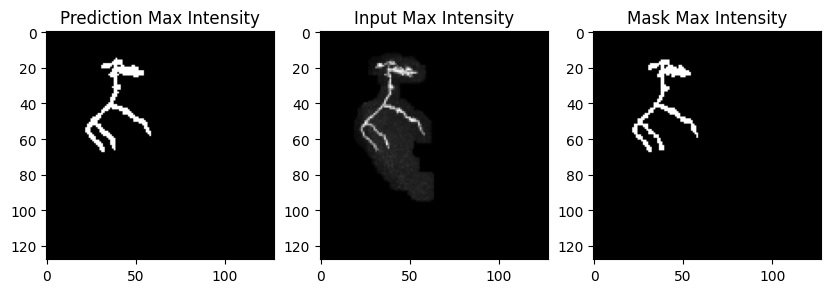

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_F3-left_optic_lobe.v3draw.extract_6.v3dpbd.tif


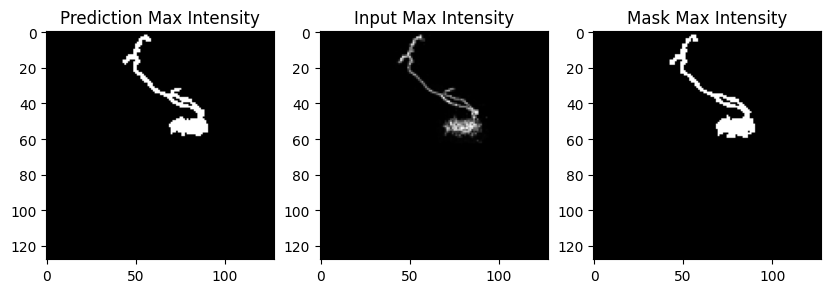

Image: fix-P7-4.5h-cell1-60x-zoom1.5_merge_c2.v3dpbd.tif


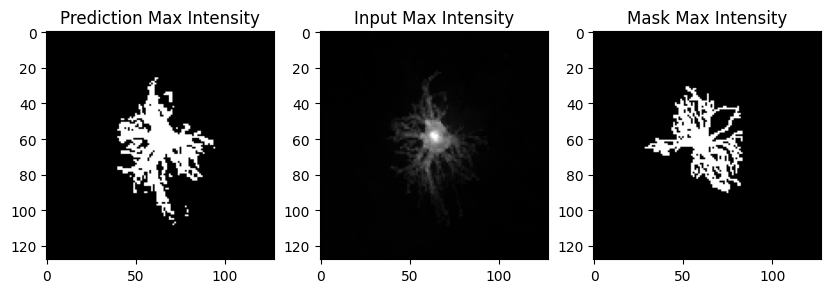

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_B2-left_optic_lobe.v3draw.extract_6.v3dpbd.tif


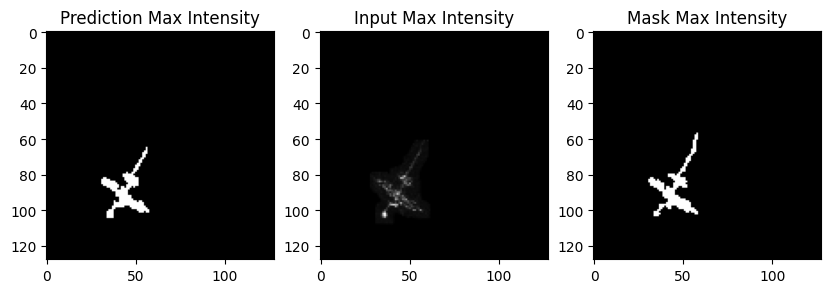

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111103_3_F3-right_optic_lobe.v3draw.extract_10.v3dpbd.tif


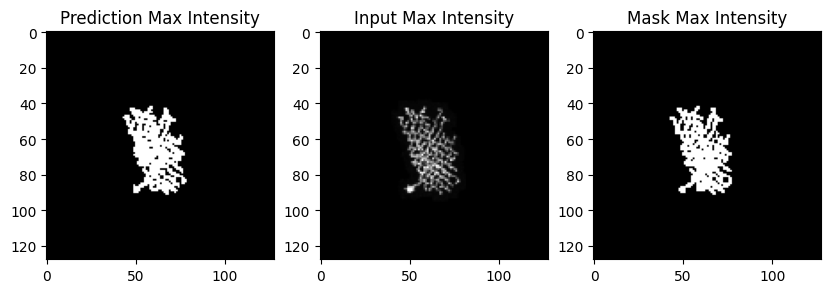

Image: uint8_ChaMARCM-F000096_seg001.lsm_c_3.tif.v3dpbd.tif


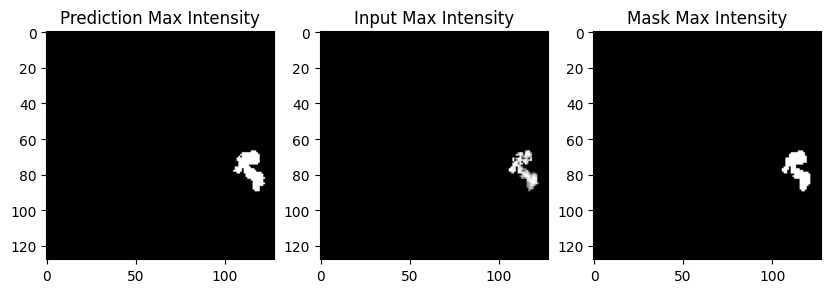

Image: 10-2909-s5-left-cell3_merge_c2.v3dpbd.tif


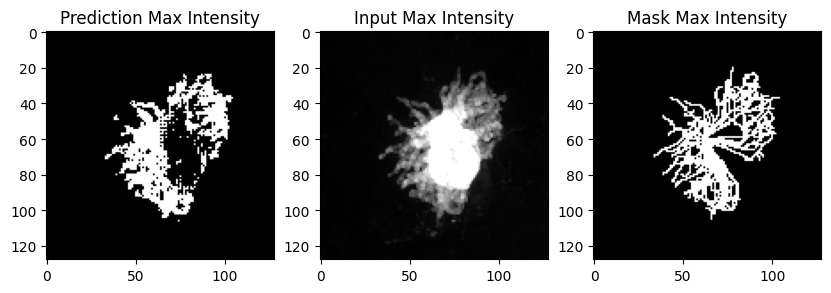

Image: Image31.v3dpbd.tif


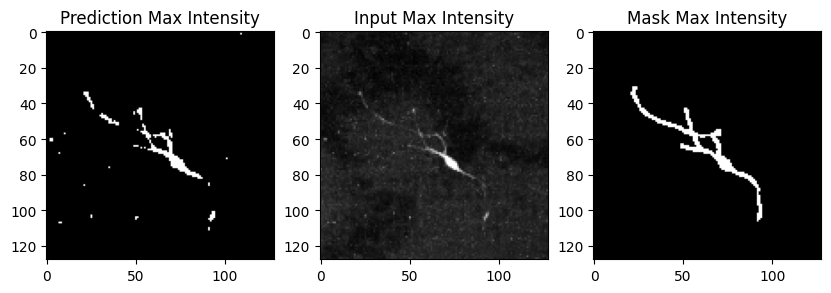

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_E1-right_optic_lobe.v3draw.extract_9.v3dpbd.tif


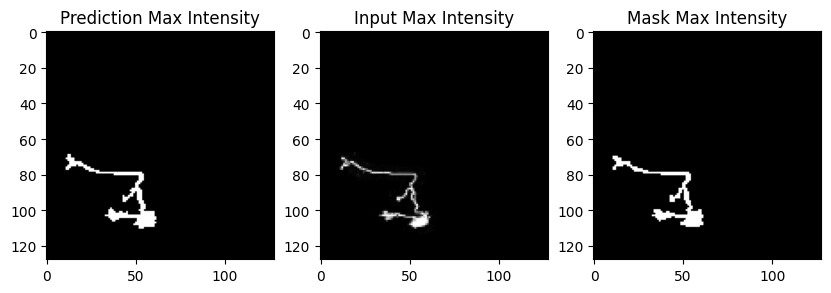

Image: uint8_ChaMARCM-F000106_seg001.lsm_c_3.tif.v3dpbd.tif


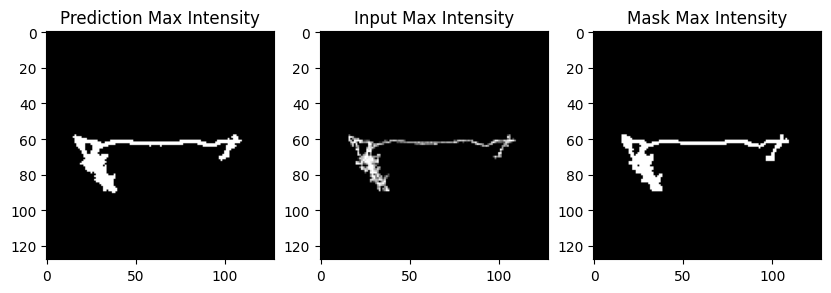

Image: uint8_ChaMARCM-F000139_seg001.lsm_c_3.tif.v3dpbd.tif


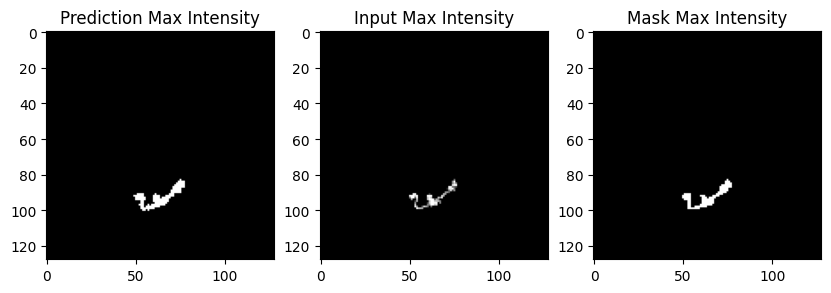

Image: 09-2902-04R-01C-60x_merge_c1.v3dpbd.tif


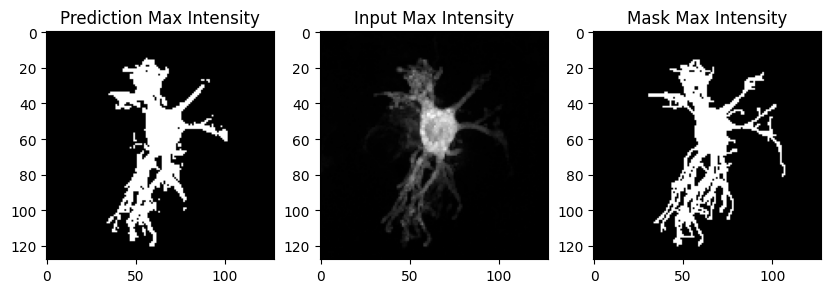

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A4-left_optic_lobe.v3draw.extract_5.v3dpbd.tif


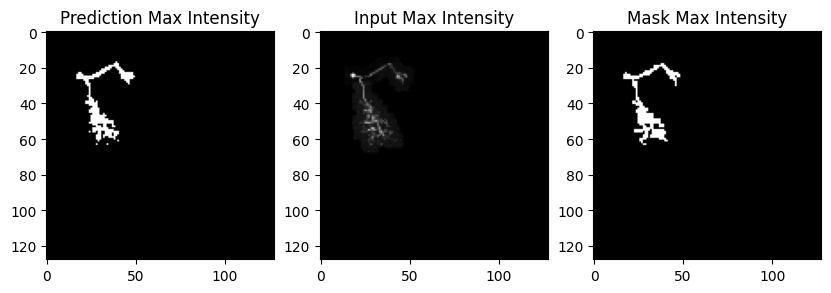

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_4_E3-left_optic_lobe.v3draw.extract_1.v3dpbd.tif


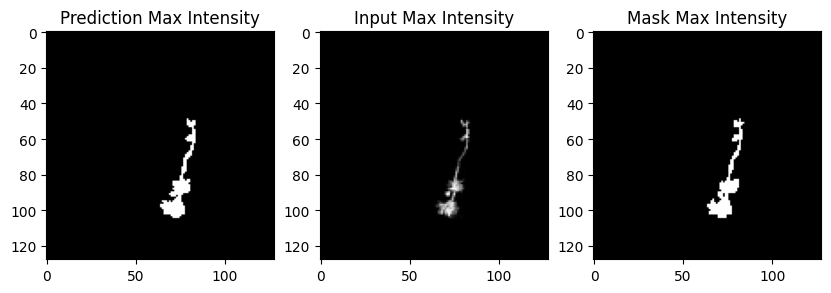

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_B1-left_optic_lobe.v3draw.extract_3.v3dpbd.tif


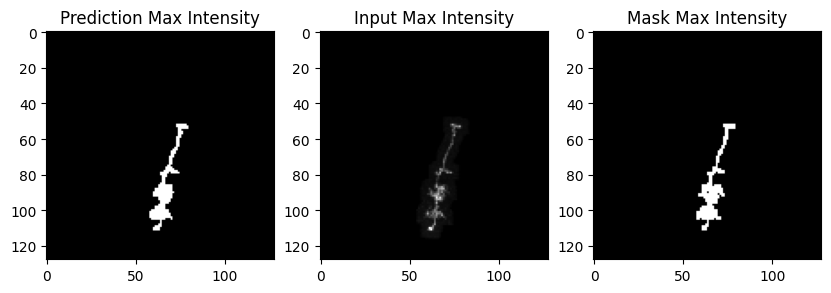

Image: uint8_ChaMARCM-F000146_seg001.lsm_c_3.tif.v3dpbd.tif


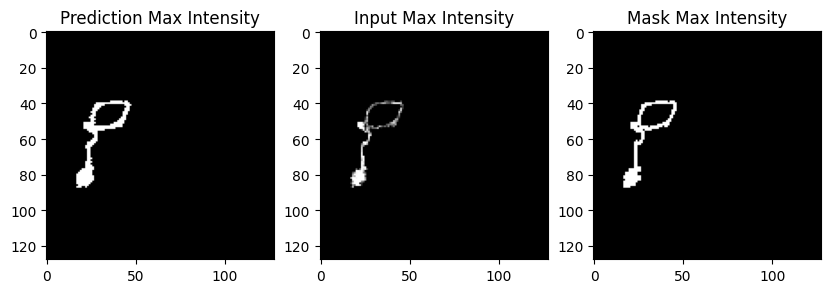

Image: uint8_ChaMARCM-F000095_seg001.lsm_c_3.tif.v3dpbd.tif


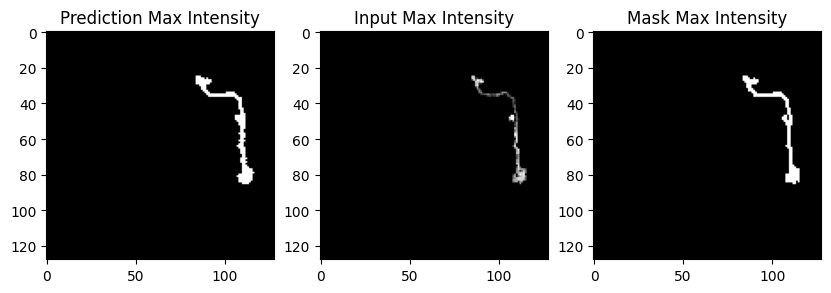

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_C1-left_optic_lobe.v3draw.extract_2.v3dpbd.tif


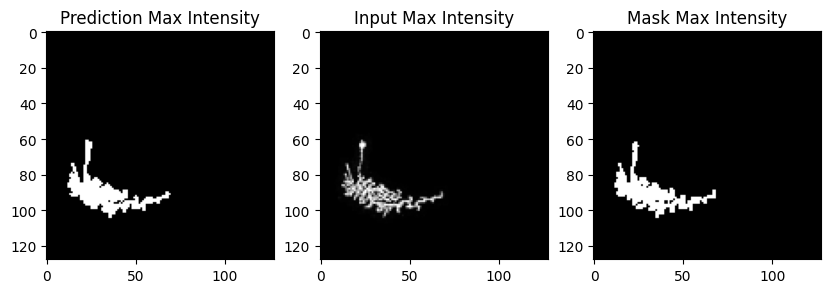

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111004_3_E2-left_optic_lobe.v3draw.extract_0.v3dpbd.tif


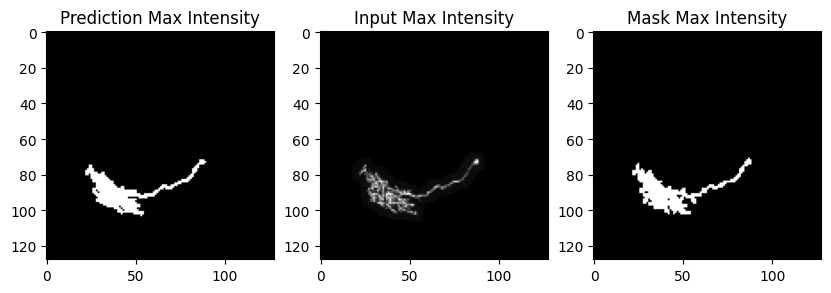

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-left_optic_lobe.v3draw.extract_6.v3dpbd.tif


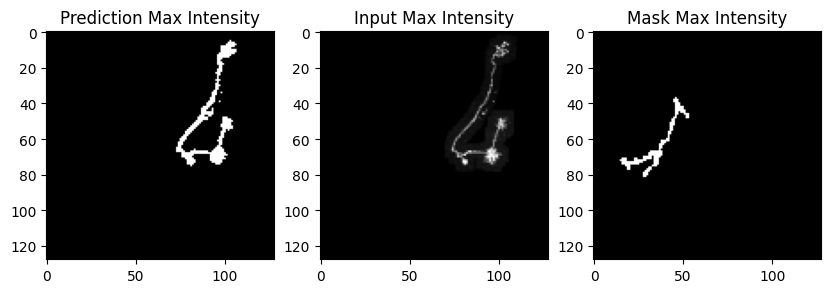

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111107_2_C5-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


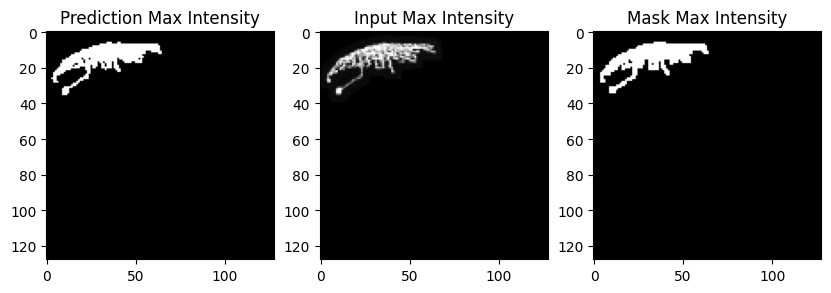

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20110929_1_B4-left_optic_lobe.v3draw.extract_1.v3dpbd.tif


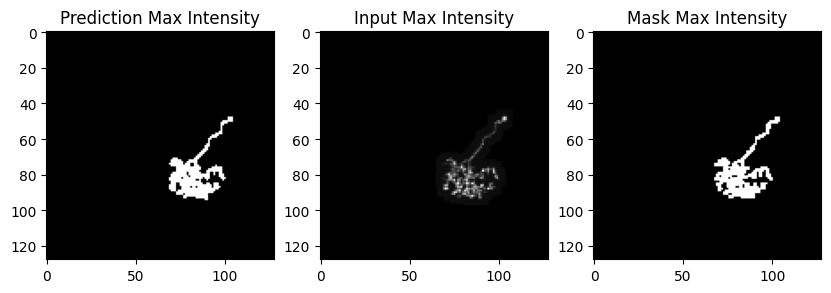

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111005_4_C6-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


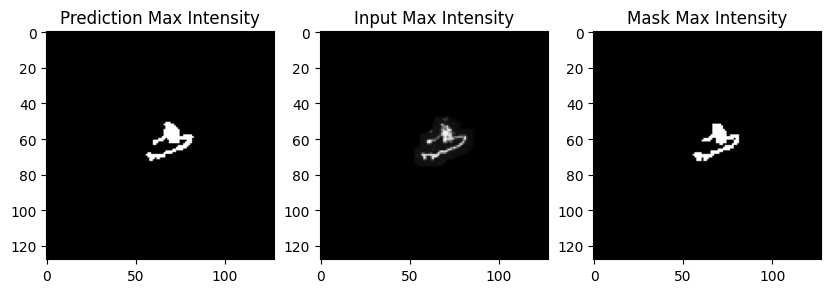

Image: uint8_ChaMARCM-F000069_seg001.lsm_c_3.tif.v3dpbd.tif


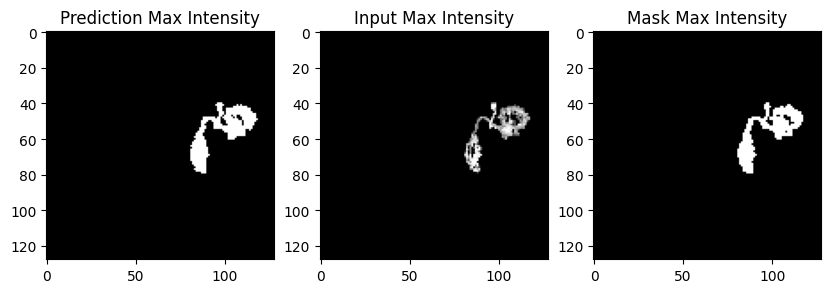

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_D2-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


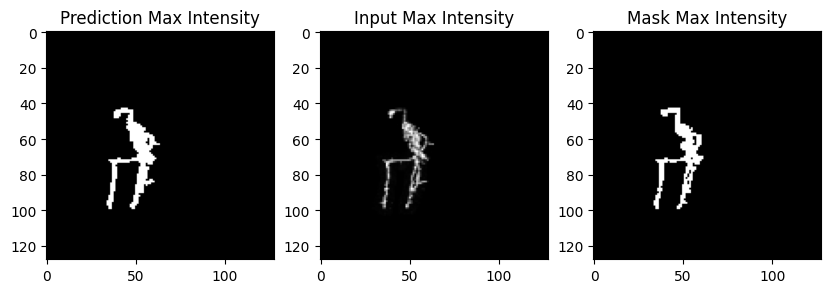

Image: 10-2912-s1-cell1_merge_c2.v3dpbd.tif


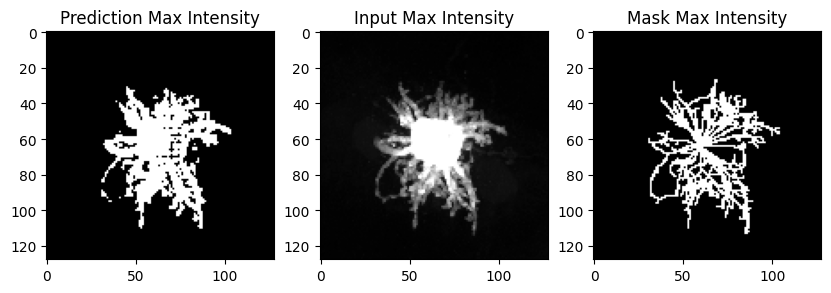

Image: uint8_ChaMARCM-F000141_seg001.lsm_c_3.tif.v3dpbd.tif


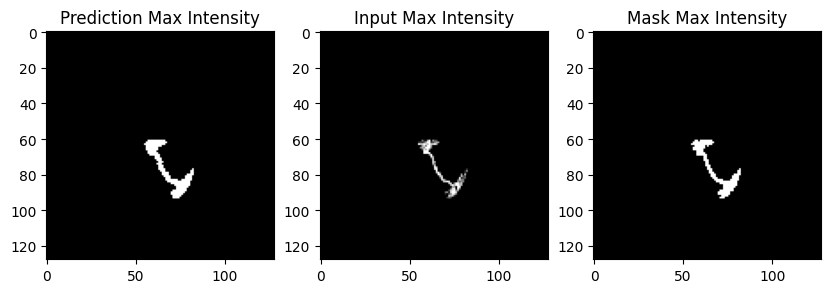

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A2-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


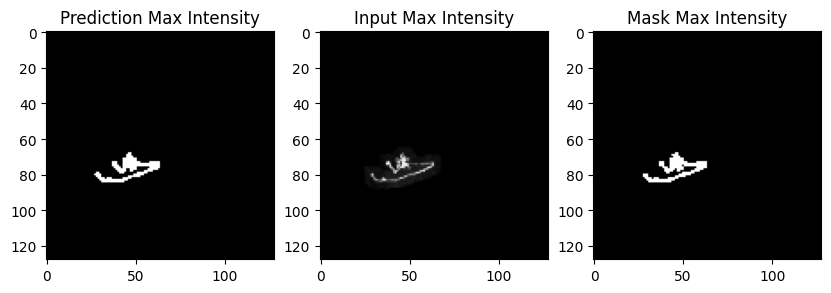

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_1_C4-right_optic_lobe.v3draw.extract_3.v3dpbd.tif


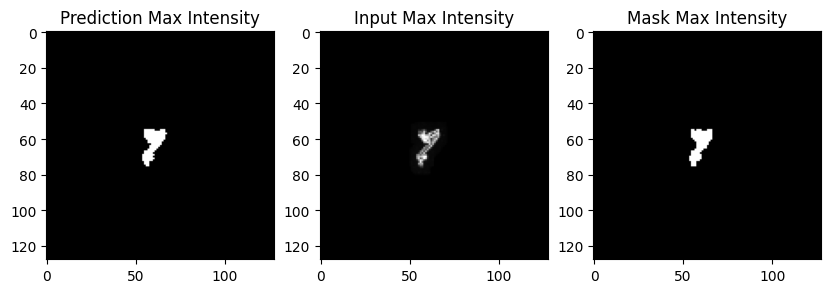

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_1_D1-right_optic_lobe.v3draw.extract_9.v3dpbd.tif


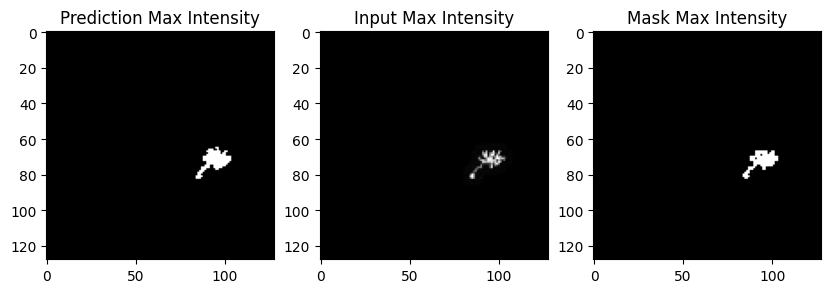

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-right_optic_lobe.v3draw.extract_3.v3dpbd.tif


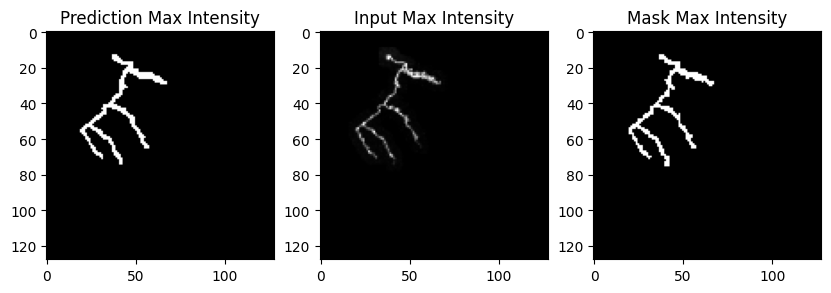

Image: uint8_ChaMARCM-F000087_seg001.lsm_c_3.tif.v3dpbd.tif


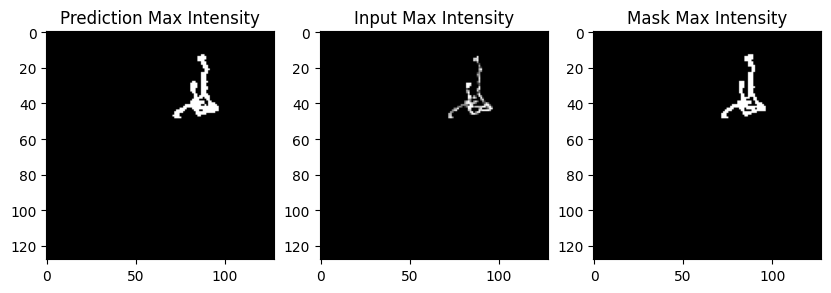

Image: uint8_ChaMARCM-F000138_seg002.lsm_c_3.tif.v3dpbd.tif


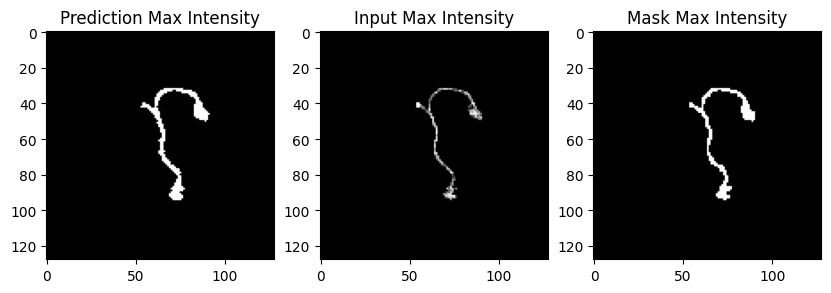

Image: uint8_ChaMARCM-F000140_seg001.lsm_c_3.tif.v3dpbd.tif


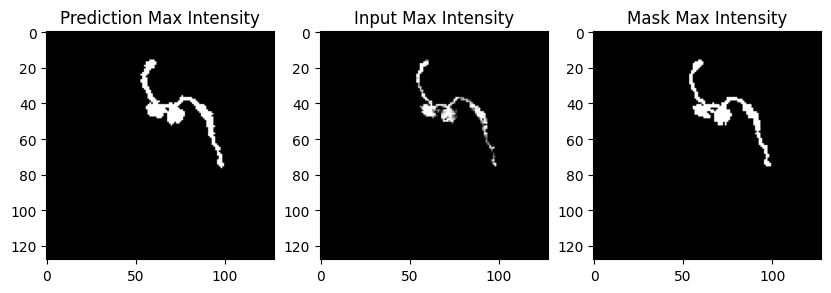

Image: Series021.v3dpbd.tif


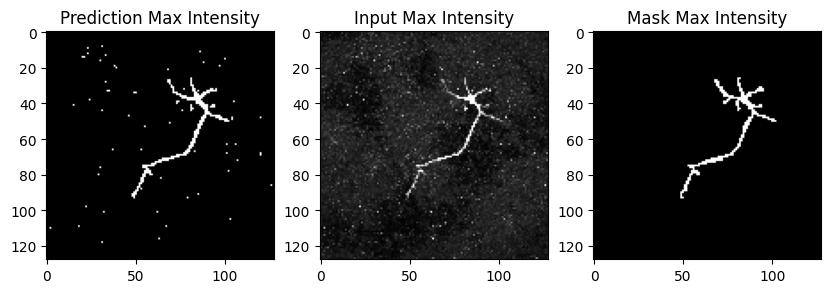

Image: Series017.v3dpbd.tif


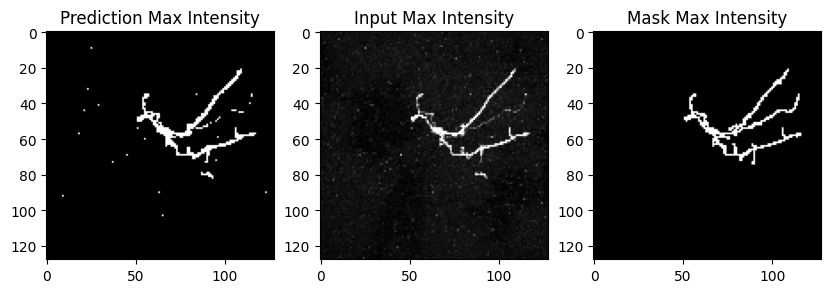

Image: uint8_ChaMARCM-F000094_seg001.lsm_c_3.tif.v3dpbd.tif


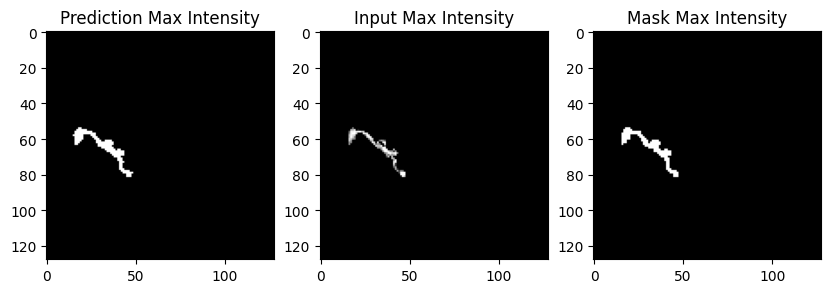

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111005_4_B1-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


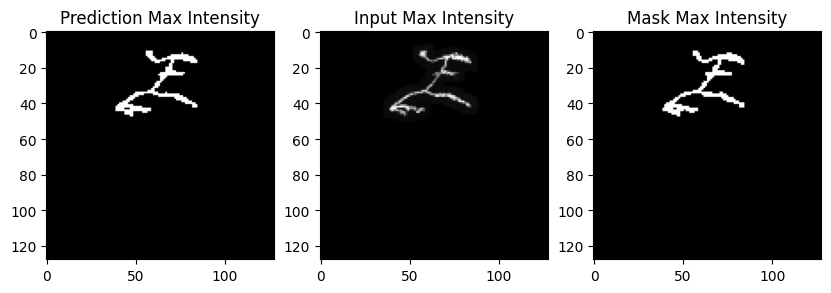

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-x-A02-20110612_1_B1-right_optic_lobe.v3draw.extract_7.v3dpbd.tif


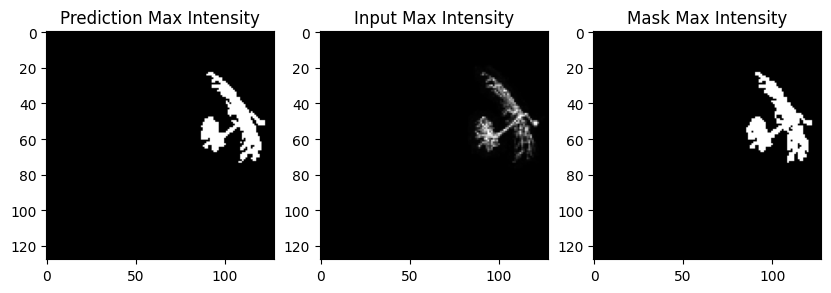

Image: uint8_ChaMARCM-F000006_seg001.lsm_c_3.tif.v3dpbd.tif


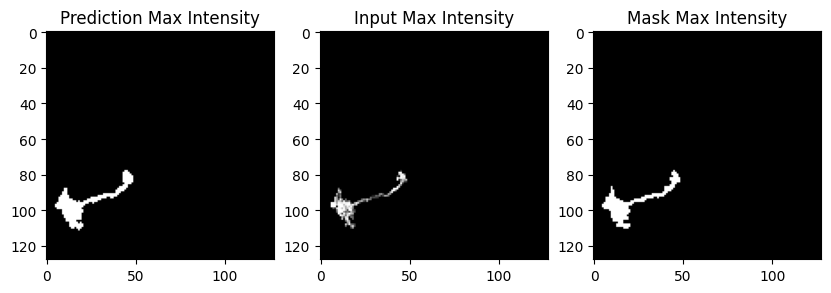

Image: Image4.v3dpbd.tif


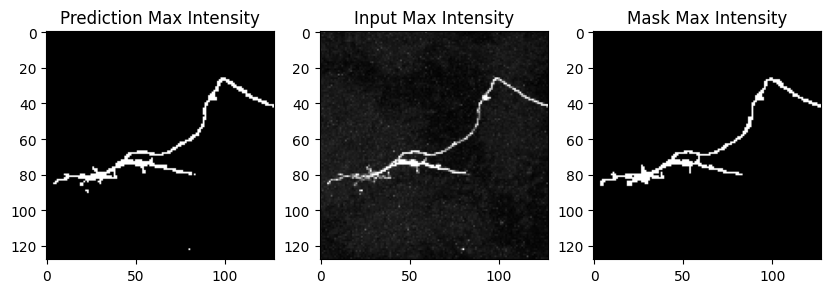

Image: case1-slide2-section1-left-cell1_merge_c2.v3dpbd.tif


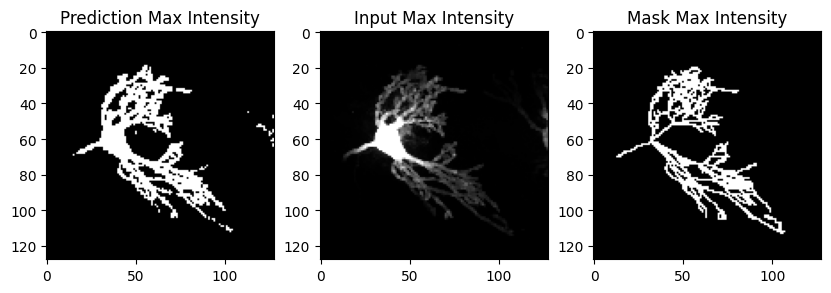

Image: uint8_ChaMARCM-F000134_seg001.lsm_c_3.tif.v3dpbd.tif


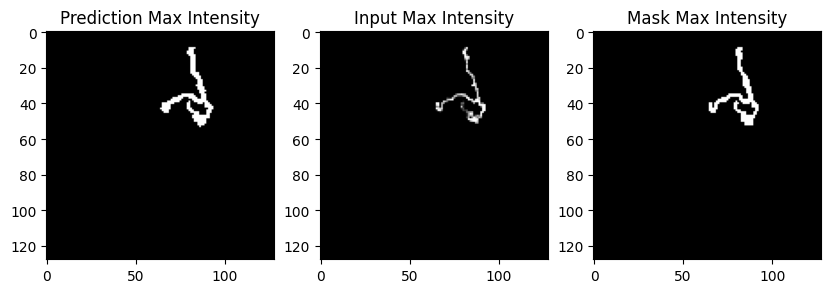

Image: Image5.v3dpbd.tif


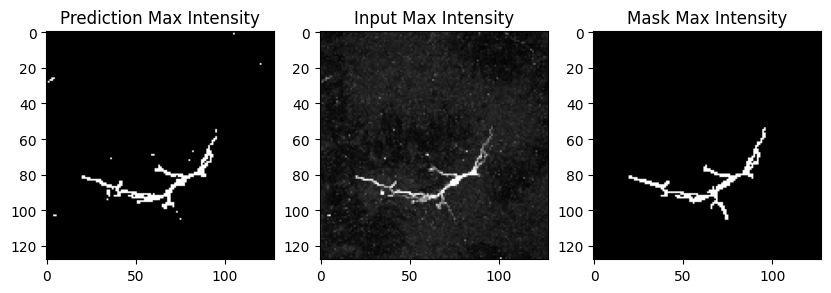

Image: uint8_ChaMARCM-F000157_seg001.lsm_c_3.tif.v3dpbd.tif


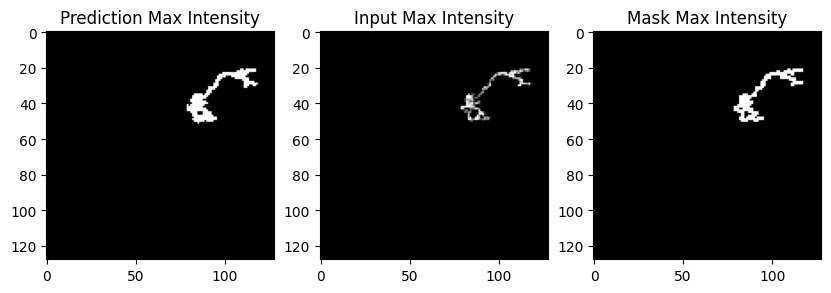

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A3-left_optic_lobe.v3draw.extract_1.v3dpbd.tif


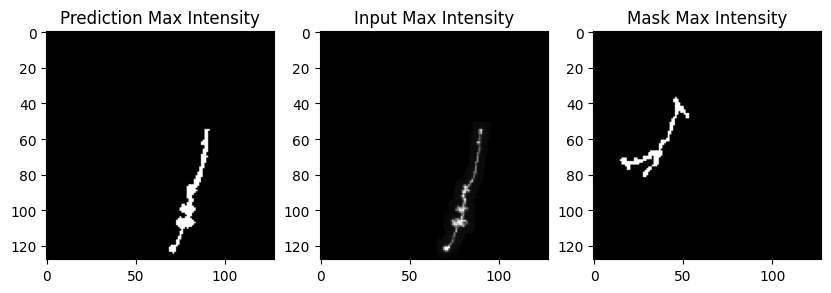

Image: uint8_ChaMARCM-F000127_seg001.lsm_c_3.tif.v3dpbd.tif


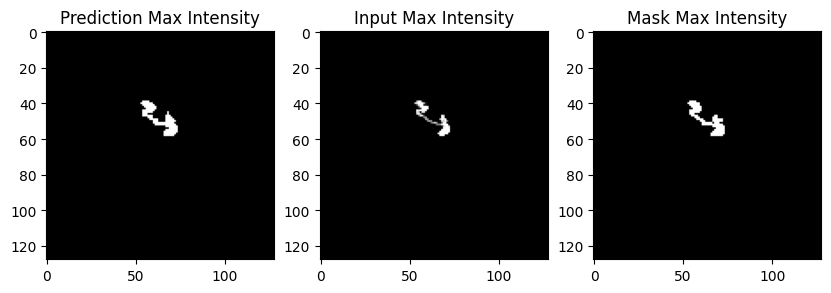

Image: fix-P7-4.5h-cell2-60x-zoom1.5_merge_c2.v3dpbd.tif


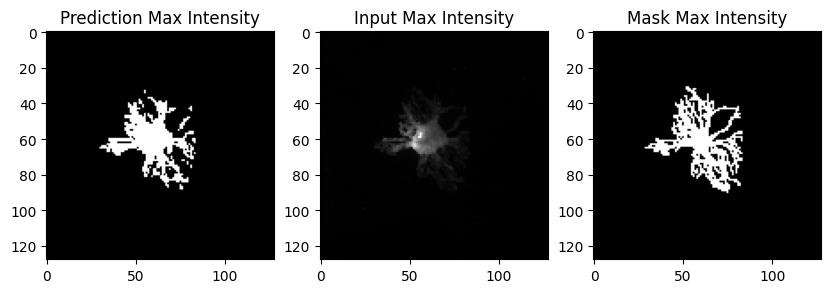

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_1_D3-left_optic_lobe.v3draw.extract_11.v3dpbd.tif


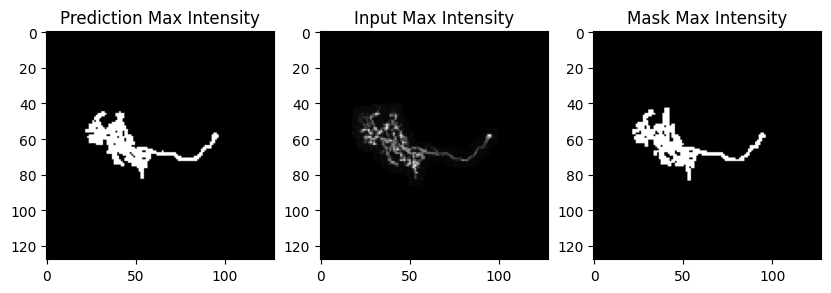

Image: GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A5-left_optic_lobe.v3draw.extract_2.v3dpbd.tif


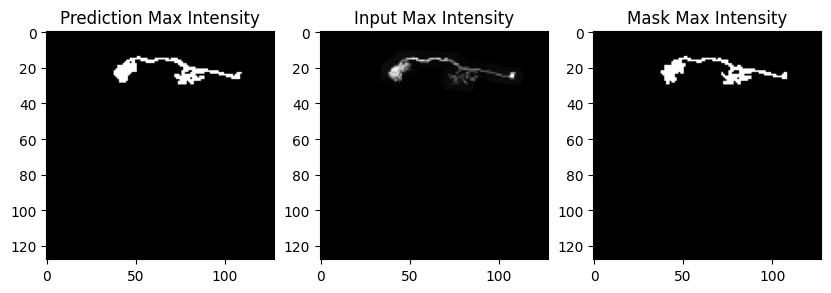

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111028_4_A5-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


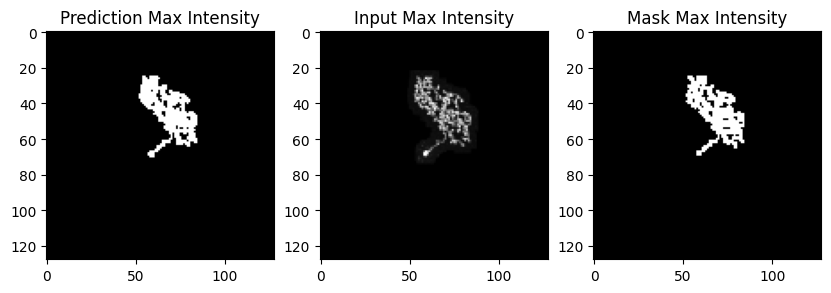

Image: uint8_ChaMARCM-F000006_seg002.lsm_c_3.tif.v3dpbd.tif


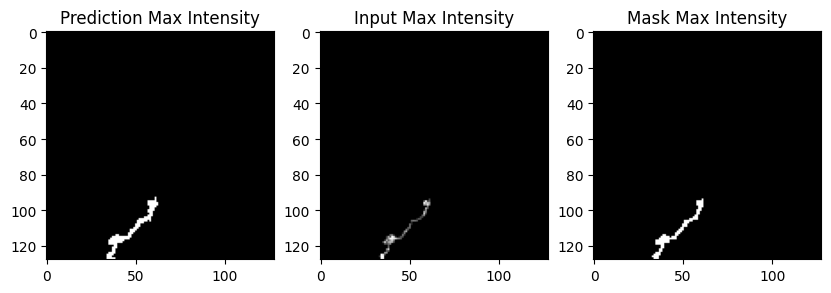

Image: Image10.v3dpbd.tif


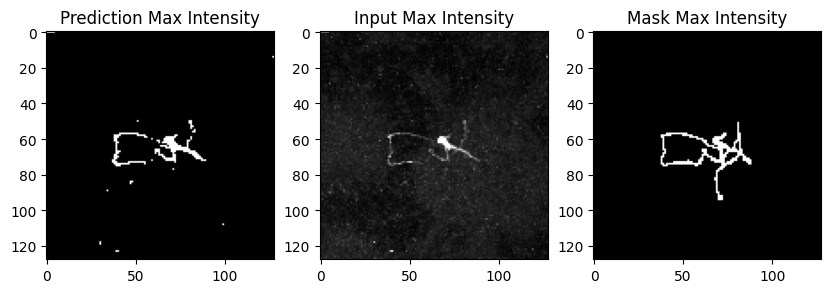

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_2_F3-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


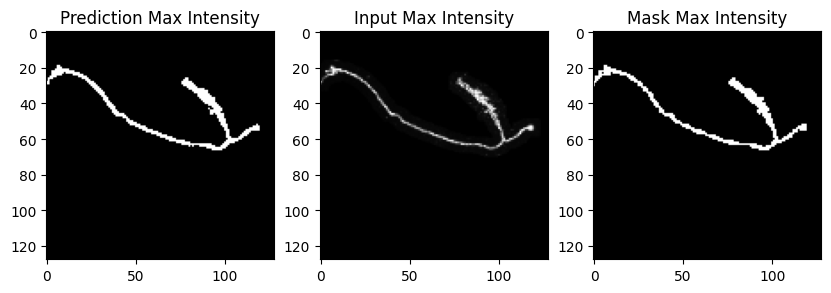

Image: uint8_ChaMARCM-F000138_seg001.lsm_c_3.tif.v3dpbd.tif


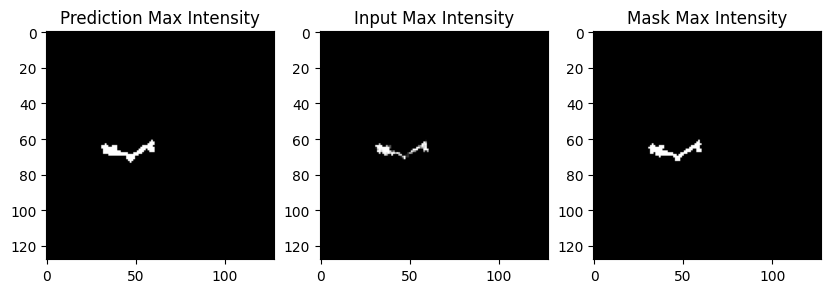

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111006_1_A4-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


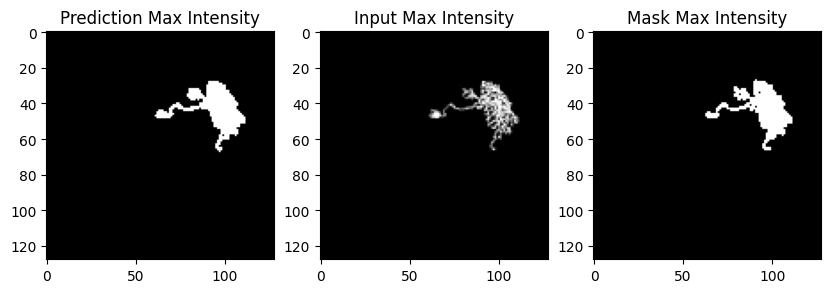

Image: uint8_ChaMARCM-F000142_seg001.lsm_c_3.tif.v3dpbd.tif


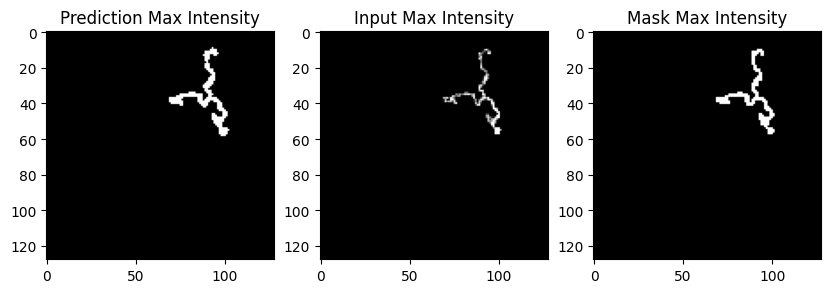

Image: case1-slide2-section2-left-cell3_merge_c2.v3dpbd.tif


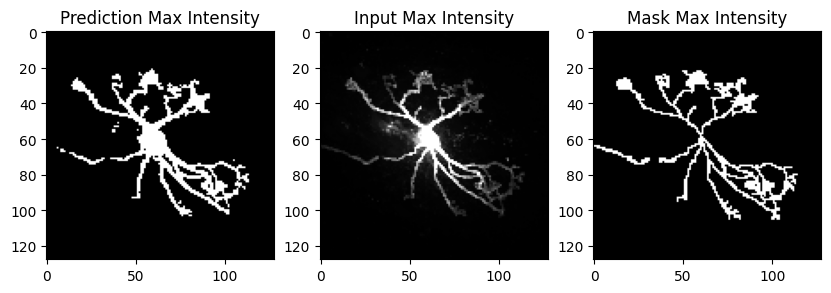

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111103_3_C1-right_optic_lobe.v3draw.extract_0.v3dpbd.tif


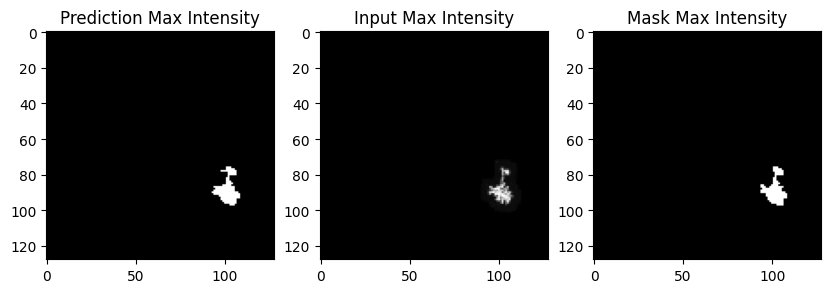

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-m-A-20111103_3_D1-left_optic_lobe.v3draw.extract_0.v3dpbd.tif


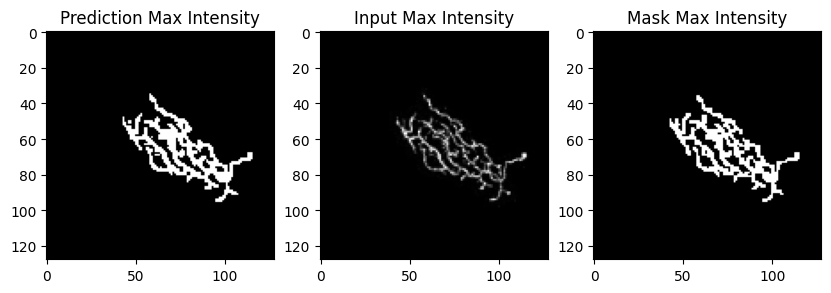

Image: GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20110929_1_D1-left_optic_lobe.v3draw.extract_0.v3dpbd.tif


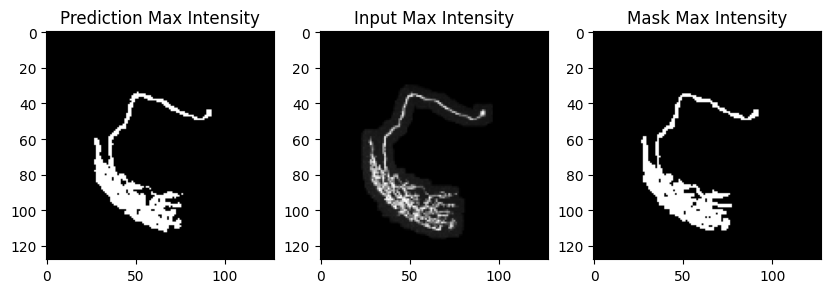

Image: uint8_ChaMARCM-F000143_seg001.lsm_c_3.tif.v3dpbd.tif


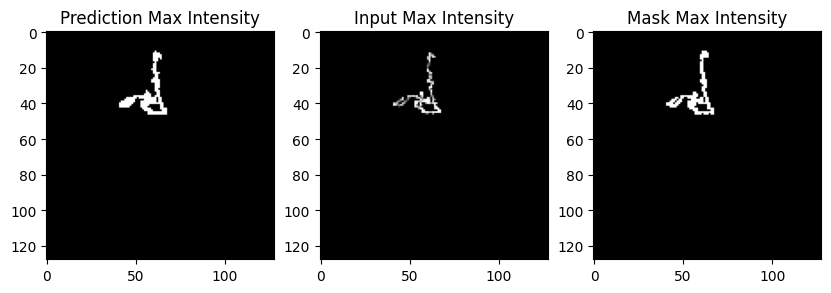

In [12]:
plot_predictions(train_dataset, save_as='', save_path='')